In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install opencv-python matplotlib onnxruntime onnx
!pip install wget

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-f0re0qlf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-f0re0qlf
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=122dbc05c5b96f8c2f3098e98805c36338b3b45904850be92718dfc98d51dc2e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ro_10p87/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 MB 5.1 MB/s eta 0:00:000m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 18.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━

In [1]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from segment_anything.utils.onnx import SamOnnxModel
import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

import torch
from copy import deepcopy
import warnings

from typing import Tuple
import wget

## Utils

In [2]:

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


class ImageTensor:
    def __init__(self, image):
        self.image = image
        self.orig_width, self.orig_height = image.size
        self.resized_width, self.resized_height = None, None
        self.pad_width, self.pad_height = None, None

    def size(self):
        return self.image.size

    def apply_coords(self, coords: np.ndarray) -> np.ndarray:
        """
        Expects a numpy array of length 2 in the final dimension
        """
        old_h, old_w = self.orig_height, self.orig_width
        new_h, new_w = self.resized_height, self.resized_width
        coords = deepcopy(coords).astype(float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords


class ImagePreprocessor:
    def __init__(self, long_side_max=1024, mean=None, std=None, image_format="RGB", pad_to_square=True):
        self.long_side_max = long_side_max
        self.mean = mean
        self.std = std
        self.image_format = image_format
        self.pad_to_square = pad_to_square
        if self.mean is None:
            self.mean = np.array([123.675, 116.28, 103.53])
        if self.std is None:
            self.std = np.array([58.395, 57.12, 57.375])


    def resize_image_to_long_side(self, img: ImageTensor):
        if self.long_side_max is None:
            return img
        orig_width, orig_height = img.image.size
        if orig_width > orig_height:
            img.resized_width = self.long_side_max
            img.resized_height = int(self.long_side_max / orig_width * orig_height)
        else:
            img.resized_height = self.long_side_max
            img.resized_width = int(self.long_side_max / orig_height * orig_width)

        img.image = img.image.resize((img.resized_width, img.resized_height), Image.Resampling.BILINEAR)
        return img

    def make_image_rgb(self, image):
        if image.image.mode == "RGB":
            return image
        else:
            image.image = image.image.convert("RGB")
            return image

    def pad_image_to_square(self, image):
        if isinstance(image, ImageTensor):
            image.image = self.pad_image_to_square(image.image)
            return image
        else:
            h, w = image.shape[2:]
            max_dim = max(h, w)
            pad_h = max_dim - h
            pad_w = max_dim - w
            image = np.pad(image, ((0,0), (0,0), (0,pad_h), (0,pad_w)), mode="constant", constant_values=0)
            return image

    def normalize_image(self, image):
        if isinstance(image, ImageTensor):
            image.image = self.normalize_image(image.image)
            return image
        else:
            image = (image - self.mean) / self.std
            return image

    def to_tensor(self, image):
        if isinstance(image, ImageTensor):
            image.image = self.to_tensor(image.image)
            return image
        else:
            image = image.transpose(2,0,1)[None,:,:,:].astype(np.float32)
            return image

    def from_image_to_input(self, image):
        image = self.make_image_rgb(image)
        image = self.resize_image_to_long_side(image)
        image = self.normalize_image(image)
        image = self.to_tensor(image)
        # pad to square
        if self.pad_to_square:
            image = self.pad_image_to_square(image)
        return image


In [4]:
# open the image of the path into an ndarray using PIL and set it as the image to be processed
image_path = R"/media/m2/repos/forks/holohub/applications/segment_everything/downloads/sample.png"
image = Image.open(image_path)

In [5]:
# image collections for plotting and testing
image_original = ImageTensor(image)
image_object = ImageTensor(image)

# image processor object
image_preprocessor = ImagePreprocessor()

image_rgb = image_preprocessor.make_image_rgb(image_object)
numpy_image = np.array(image_rgb.image)
input_image = image_preprocessor.from_image_to_input(image_object)


In [6]:
# https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
# https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
# https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

class ModelDownloader:
    def __init__(self, download_url:str=None) -> None:
        if download_url is None:
            download_url = R"https://dl.fbaipublicfiles.com/segment_anything/"
        self.models = {
            "sam_vit_h": download_url + "sam_vit_h_4b8939.pth",
            "sam_vit_b": download_url + "sam_vit_b_01ec64.pth",
            "sam_vit_l": download_url + "sam_vit_l_0b3195.pth",
        }

    def download_model(self, model_type, filepath:str=None):
        if filepath is None:
            # create a download folder in the current directory and use it to save the models there
            filedir = os.path.join(os.getcwd(), "downloads")
            os.makedirs(filedir, exist_ok=True)
            filepath = os.path.join(filedir, f"{model_type}.pth")
        if model_type not in self.models:
            raise ValueError("Invalid model_type")
        # only download the model if it doesn't already exist
        if os.path.exists(filepath):
            return filepath
        else:
            print(f"Downloading model: {model_type}")
            url = self.models[model_type]
            wget.download(url, filepath)

        return filepath

downloader = ModelDownloader()
for model_type in ["sam_vit_h", "sam_vit_b", "sam_vit_l"]:
    downloaded_filepath = downloader.download_model(model_type)
    print(f"Model downloaded to: {downloaded_filepath}")


Model downloaded to: /media/m2/repos/forks/holohub/applications/segment_everything/downloads/sam_vit_h.pth
Model downloaded to: /media/m2/repos/forks/holohub/applications/segment_everything/downloads/sam_vit_b.pth
Model downloaded to: /media/m2/repos/forks/holohub/applications/segment_everything/downloads/sam_vit_l.pth


## pytorch model usage 

In [ ]:
# download a model
# !python -m wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
sam = sam_model_registry["vit_b"](R"C:\Users\mmoller\Downloads\sam_vit_b_01ec64.pth")

In [ ]:
#plotting a query point on the image
input_point = np.array([[1000, 600]])
input_label = np.array([1])
# format of the box is [x0, y0, x1, y1], where o is the top left corner and 1 is the bottom right corner
input_box = np.array([800, 150, 1250, 800])

plt.figure(figsize=(10,10))
plt.imshow(image_rgb.image)
show_points(input_point, input_label, plt.gca())
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
plt.imshow(image_rgb.image)

In [ ]:
predictor = SamPredictor(sam)


In [ ]:
predictor.set_image(numpy_image)

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(numpy_image)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

# Export encoder and decoder to onnx


In [8]:
model_type = "vit_l"
checkpoint_path = os.path.join(os.getcwd(), "downloads", f"sam_{model_type}.pth")
onnx_decoder_path = os.path.join(os.getcwd(), "onnx", f"sam_{model_type}_query_decoder.onnx")
onnx_encoder_path = os.path.join(os.getcwd(), "onnx", f"sam_{model_type}_encoder.onnx")
if not os.path.exists(os.path.dirname(onnx_decoder_path)):
    os.makedirs(os.path.dirname(onnx_decoder_path))

In [8]:
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)

In [9]:
onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_decoder_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )

    with open(onnx_encoder_path, "wb") as f:
    # Export images encoder from SAM model to ONNX
        torch.onnx.export(
            f=f,
            model=sam.image_encoder,
            args=torch.randn(1, 3, 1024, 1024),
            input_names=["images"],
            output_names=["embeddings"],
            export_params=True
    )

# using the local onnx model decoder 


In [10]:

sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
ort_session = onnxruntime.InferenceSession(onnx_decoder_path)
sam.to(device='cuda')
predictor = SamPredictor(sam)

In [ ]:
predictor.set_image(numpy_image)

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(numpy_image)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

# Test encoder and decoder

In [9]:
# Testing encoder and decoder on an image
encoder = onnxruntime.InferenceSession(onnx_encoder_path, providers=["CUDAExecutionProvider"])
decoder = onnxruntime.InferenceSession(onnx_decoder_path, providers=["CUDAExecutionProvider"])

/media/m2/repos/forks/holohub/.conda/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [18]:
outputs = encoder.run(None, {"images": input_image.image})
embeddings = outputs[0]


((1, 256, 64, 64), (1, 3, 1024, 1024))

In [19]:
embeddings.shape, input_image.image.shape

((1, 256, 64, 64), (1, 3, 1024, 1024))

In [11]:
for output in outputs:
    print(type(output), output.shape)

<class 'numpy.ndarray'> (1, 256, 64, 64)


## instructions from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/onnx_model_example.ipynb
The ONNX model has a different input signature than SamPredictor.predict. The following inputs must all be supplied. Note the special cases for both point and mask inputs. All inputs are np.float32.

- image_embeddings: The image embedding from predictor.get_image_embedding(). Has a batch index of length 1.
- point_coords: Coordinates of sparse input prompts, corresponding to both point inputs and box inputs. Boxes are encoded using two points, one for the top-left corner and one for the bottom-right corner. Coordinates must already be transformed to long-side 1024. Has a batch index of length 1.
- point_labels: Labels for the sparse input prompts. 0 is a negative input point, 1 is a positive input point, 2 is a top-left box corner, 3 is a bottom-right box corner, and -1 is a padding point. If there is no box input, a single padding point with label -1 and coordinates (0.0, 0.0) should be concatenated.
- mask_input: A mask input to the model with shape 1x1x256x256. This must be supplied even if there is no mask input. In this case, it can just be zeros.
- has_mask_input: An indicator for the mask input. 1 indicates a mask input, 0 indicates no mask input.
- orig_im_size: The size of the input image in (H,W) format, before any transformation.

Additionally, the ONNX model does not threshold the output mask logits. To obtain a binary mask, threshold at sam.mask_threshold (equal to 0.0).


In [12]:

image_size = np.array([image_rgb.orig_width, image_rgb.orig_height ], dtype=np.float32)
#plotting a query point on the image
input_point = np.array([[1000, 600]])
# label 1 means foreground, 0 means background
input_label = np.array([1])
# format of the box is [x0, y0, x1, y1], where o is the top left corner and 1 is the bottom right corner
input_box = np.array([400, 250, 2500, 1500])
box_labels = np.array([2, 3])

onnx_box_coords = input_box.reshape(2, 2)
onnx_box_labels = np.array([2,3])

onnx_coord = np.concatenate([input_point, onnx_box_coords], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, onnx_box_labels], axis=0)[None, :].astype(np.float32)
onnx_coord = input_image.apply_coords(onnx_coord).astype(np.float32)
# onnx_coord = predictor.transform.apply_coords(onnx_coord, image_size).astype(np.float32)

onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

orig_im_size = np.array([input_image.orig_height, input_image.orig_width], dtype=np.float32)

In [13]:
outputs = decoder.run(None,{
    "image_embeddings": embeddings,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": orig_im_size,
})

In [14]:
masks = outputs[0]


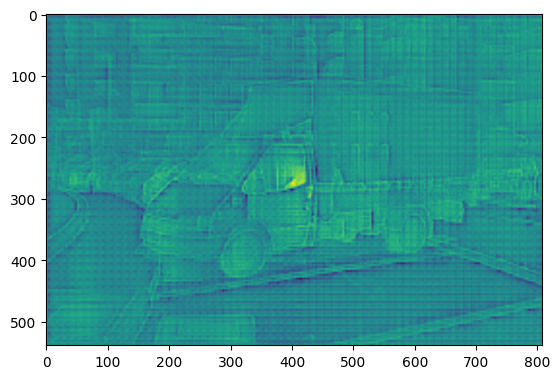

In [15]:
plt.imshow(masks[0,0])

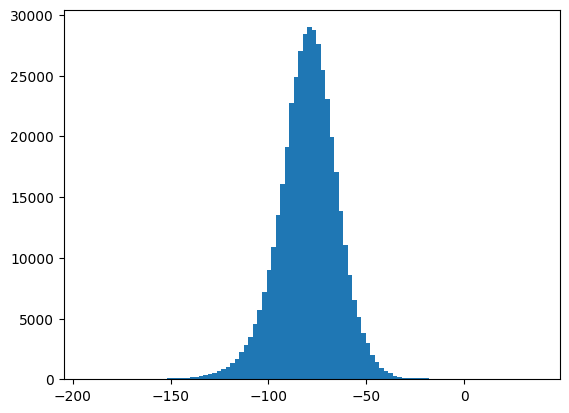

In [16]:
_ = plt.hist(masks[0,0].flatten(), bins=100)

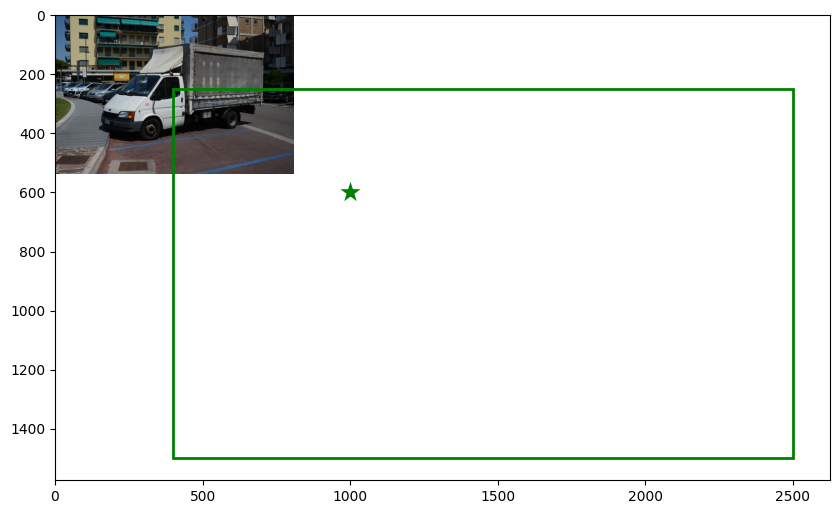

In [17]:
mask = masks[0,0,...]
mask = mask > 0

plt.figure(figsize=(10, 10))
plt.imshow(image_original.image)
show_mask(mask, plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.show()